In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
import random


import os, sys
sys.path.insert(0,'..')

from collections import deque 

from dfibert.tracker.nn.rl import Agent, Action_Scheduler, DQN
import dfibert.envs.RLtractEnvironment as RLTe
from dfibert.envs._state import TractographyState

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
env = RLTe.RLtractEnvironment(stepWidth=0.1, action_space=20, maxL2dist_to_State=0.2, device = 'cpu', pReferenceStreamlines='data/HCP307200_DTI_min40.vtk')
#env = RLTe.RLtractEnvironment(stepWidth=0.3, action_space=20, device = 'cpu', pReferenceStreamlines='data/HCP307200_DTI_min40.vtk')
n_actions = env.action_space.n

Loading precomputed streamlines (data/HCP307200_DTI_min40.vtk) for ID 100307


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
max_steps = 30000000
replay_memory_size = 100000
agent_history_length = 1
evaluate_every = 200000
eval_runs = 5#20
network_update_every = 1000
start_learning = 10000
eps_annealing_steps = 400000

max_episode_length = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 512
learning_rate = 0.0001 

In [4]:
state = env.reset().getValue()
print(state.shape)
agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.99, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(100, 3, 3, 3)


In [5]:
#### Fill replay memory with perfect actions for supervised approach

from tqdm import trange
state = env.reset().getValue()
agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, gamma=0.99, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=512, learning_rate=learning_rate)

overall_runs = 0
overall_reward = []
for overall_runs in trange(30):
    state = env.reset(streamline_index=overall_runs)
    #episode_step_counter = 0
    episode_reward = 0
    terminal = False
    #print("New run")
    #print(env.stepCounter, state.getCoordinate().numpy())
    while not terminal:
        #print(env.stepCounter)
        #if np.random.rand(1) < 0.1: 
        #    action = np.random.randint(0, n_actions)
        #else:
        action = env._get_best_action()
        next_state, reward, terminal, _ = env.step(action)
        
            
        agent.replay_memory.add_experience(action=action,
                                state = state.getValue(),
                                reward=reward,
                                new_state = next_state.getValue(),
                                terminal=terminal)
        
        episode_reward += reward
        
        state = next_state
        
        if terminal == True:
            break
            
    overall_runs += 1
    overall_reward.append(episode_reward)
    print(overall_runs, np.mean(overall_reward[-100:]))
print("Replay memory ready")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/30 [00:00<?, ?it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  3%|▎         | 1/30 [00:17<08:35, 17.78s/it]

Defi reached the terminal state!
1 327.2326269974001


  7%|▋         | 2/30 [00:28<07:21, 15.76s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 10%|█         | 3/30 [00:49<07:43, 17.16s/it]

Defi reached the terminal state!
3 285.8552310552138


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 13%|█▎        | 4/30 [01:11<08:09, 18.81s/it]

Defi reached the terminal state!
4 384.7048972687917


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 17%|█▋        | 5/30 [01:30<07:50, 18.81s/it]

Defi reached the terminal state!
5 404.83197887176647


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 20%|██        | 6/30 [01:45<07:04, 17.69s/it]

Mean of all step angles too high! Step counter: 342, Mean: 0.8205126739949786
6 365.97566485226463


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 23%|██▎       | 7/30 [02:00<06:25, 16.77s/it]

Defi reached the terminal state!
7 343.2333160038106


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 27%|██▋       | 8/30 [02:13<05:43, 15.61s/it]

Mean of all step angles too high! Step counter: 103, Mean: 0.8217800461848211
8 306.76973854895914


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 30%|███       | 9/30 [02:33<05:53, 16.85s/it]

Defi reached the terminal state!
9 322.6333295012721


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 33%|███▎      | 10/30 [02:50<05:40, 17.02s/it]

Mean of all step angles too high! Step counter: 531, Mean: 0.8208357587469275
10 317.1129634735174


 37%|███▋      | 11/30 [03:01<04:50, 15.28s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 40%|████      | 12/30 [03:15<04:28, 14.90s/it]

Defi reached the terminal state!
12 278.8015042607828


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 43%|████▎     | 13/30 [03:29<04:06, 14.50s/it]

Defi reached the terminal state!
13 267.5048201707765


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 47%|████▋     | 14/30 [03:41<03:40, 13.76s/it]

Mean of all step angles too high! Step counter: 25, Mean: 0.8401959275011718
14 249.31586104674665


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 50%|█████     | 15/30 [04:18<05:12, 20.80s/it]

Defi reached the terminal state!
15 304.0012799500177


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 53%|█████▎    | 16/30 [04:40<04:54, 21.06s/it]

Defi reached the terminal state!
16 323.1269873077399


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 57%|█████▋    | 17/30 [04:55<04:09, 19.22s/it]

Defi reached the terminal state!
17 319.9868494517115


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 60%|██████    | 18/30 [05:12<03:42, 18.56s/it]

Defi reached the terminal state!
18 321.23263603609263


 63%|██████▎   | 19/30 [05:23<02:59, 16.31s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 67%|██████▋   | 20/30 [05:35<02:29, 14.99s/it]

Mean of all step angles too high! Step counter: 4, Mean: 0.8763761288230875
20 289.61772547955627


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 70%|███████   | 21/30 [05:46<02:05, 13.98s/it]

Mean of all step angles too high! Step counter: 5, Mean: 0.9021755422407509
21 275.9459493887123


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 73%|███████▎  | 22/30 [06:26<02:52, 21.57s/it]

Defi reached the terminal state!
22 310.3387677420608


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 77%|███████▋  | 23/30 [06:39<02:13, 19.04s/it]

Mean of all step angles too high! Step counter: 125, Mean: 0.8219026312150037
23 299.73169559559216


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 80%|████████  | 24/30 [06:51<01:42, 17.09s/it]

Mean of all step angles too high! Step counter: 65, Mean: 0.8240320907792369
24 288.630116877408


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 83%|████████▎ | 25/30 [07:18<01:40, 20.03s/it]

Defi reached the terminal state!
25 309.9212260823417


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 87%|████████▋ | 26/30 [07:30<01:10, 17.70s/it]

Mean of all step angles too high! Step counter: 36, Mean: 0.8223991592253689
26 298.72185685819625


 90%|█████████ | 27/30 [07:42<00:47, 15.75s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 93%|█████████▎| 28/30 [08:05<00:35, 17.96s/it]

Defi reached the terminal state!
28 299.66799207501543


 97%|█████████▋| 29/30 [08:16<00:15, 15.94s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 30/30 [08:27<00:00, 16.93s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Training cell

100%|██████████| 70000/70000 [09:02<00:00, 129.14it/s]


<IPython.core.display.Javascript object>


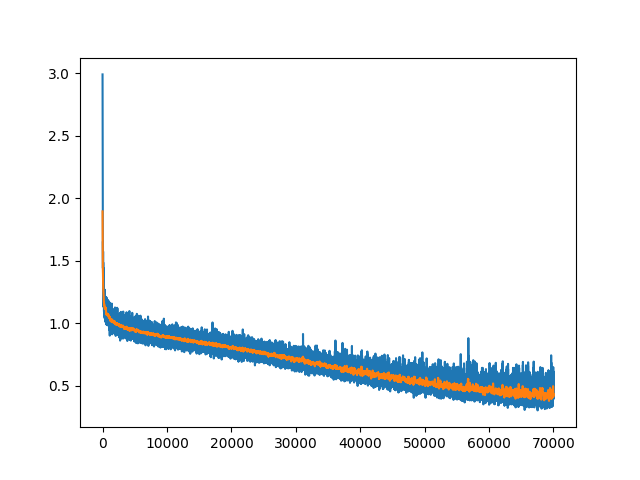

In [6]:
torch.optim.Adam(agent.target_dqn.parameters(), 0.0001)
losses = []
for i in trange(70000):
    states, actions, _, _, _ = agent.replay_memory.get_minibatch()

    states = torch.FloatTensor(states).to(agent.device)
    actions = torch.LongTensor(actions).to(agent.device)
    predicted_q = agent.main_dqn(states)
    loss = torch.nn.functional.cross_entropy(predicted_q, actions)
    #print(loss.item())
    agent.optimizer.zero_grad()
    loss.backward()
    agent.optimizer.step()
    losses.append(loss.item())
    
mean_losses = []
for i in range(len(losses)):
    mean_losses.append(np.mean(losses[i:i+99]))
#print(mean_losses[-20:])

fig, ax = plt.subplots()
ax.plot(range(len(losses[:])), losses[:])
ax.plot(range(len(losses[:])), mean_losses[:])
plt.show()

In [18]:
states, actions, _, _, _ = agent.replay_memory.get_minibatch()
states = torch.FloatTensor(states).to(agent.device)
predicted_q = torch.argmax(agent.main_dqn(states), dim=1)

false = 0
for i in range(len(actions)):
    if predicted_q[i] != actions[i]:
        false += 1 
    
print("Accuracy =", 1 - false / len(actions))

Accuracy = 0.794921875


In [19]:
step_counter = 0
eps_rewards = []
episode_lengths = []

eps = 1.0

print("Start training...")
while step_counter < max_steps:
    epoch_step = 0
    while (epoch_step < evaluate_every) or (step_counter < start_learning):
        state = env.reset()
        episode_reward_sum = 0
        terminal = False
        episode_step_counter = 0
        positive_run = 0
        points_visited = 0
        
        negative_rewards = 0
        
        
        # reduce epsilon
        if step_counter > start_learning:
            eps = max(eps * 0.999, 0.01)
        
        # play an episode
        while episode_step_counter <= 1000.:
            
            # get an action with epsilon-greedy strategy
            if random.random() < eps:                                 
                action = np.random.randint(env.action_space.n)           # either random action
                #action = env._get_best_action()
            else:                                                        # or action from agent
                agent.main_dqn.eval()
                with torch.no_grad():
                    state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
                    action = torch.argmax(agent.main_dqn(state_v)).item()
                agent.main_dqn.train()
            
            # perform step on environment
            next_state, reward, terminal, _ = env.step(action)

            
            episode_step_counter += 1
            step_counter += 1
            epoch_step += 1
            
            episode_reward_sum += reward
            
            # store experience in replay buffer
            agent.replay_memory.add_experience(action=action, state = state.getValue(), reward=reward, new_state = next_state.getValue(), terminal=terminal)
            
            state = next_state
            
            # optimize agent after certain amount of steps
            if step_counter > start_learning and step_counter % 4 == 0:
                
                # original optimization function
                #agent.optimize()
                
                ### debugging optimization function
                
                states, actions, rewards, new_states, terminal_flags = agent.replay_memory.get_minibatch()
                
                #states = torch.tensor(states)#.view(replay_memory.batch_size, -1) # 1, -1
                #next_states = torch.tensor(new_states)#.view(replay_memory.batch_size, -1)
                #actions = torch.LongTensor(actions)
                #rewards = torch.tensor(rewards)
                #terminal_flags = torch.BoolTensor(terminal_flags)

                states = torch.from_numpy(states).to(device)
                next_states = torch.from_numpy(new_states).to(device)
                actions = torch.from_numpy(actions).unsqueeze(1).long().to(device)
                rewards = torch.from_numpy(rewards).to(device)
                terminal_flags = torch.from_numpy(terminal_flags).to(device)
                
                
                state_action_values = agent.main_dqn(states).gather(1, actions).squeeze(-1)
                next_state_actions = torch.argmax(agent.main_dqn(next_states), dim=1)
                next_state_values = target_net(agent.next_states).gather(1, next_state_actions.unsqueeze(-1)).squeeze(-1)
                #
                next_state_values[terminal_flags] = 0.0
                #
                expected_state_action_values = next_state_values.detach() * 0.9995 + rewards
                #
                loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
                agent.optimizer.zero_grad()
                loss.backward()
                agent.optimizer.step()
                
            # update target network after certain amount of steps    
            #if step_counter > start_learning and step_counter % network_update_every == 0:
            #    agent.target_net.load_state_dict(agent.main_dqn.state_dict())
            
            # if epsiode has ended, step out of the episode while loop
            if terminal:
                break
                
        # keep track of past episode rewards
        eps_rewards.append(episode_reward_sum)
        if len(eps_rewards) % 20 == 0:
            print("{}, done {} episodes, {}, current eps {}".format(step_counter, len(eps_rewards), np.mean(eps_rewards[-100:]), eps))#action_scheduler.eps_current))
            
    ## evaluation        
    eval_rewards = []
    episode_final = 0
    agent.main_dqn.eval()
    for _ in range(eval_runs):
        eval_steps = 0
        state = env.reset()
        
        eval_episode_reward = 0
        negative_rewards = 0
        
        # play an episode
        while eval_steps < 1000:
            # get the action from the agent
            with torch.no_grad():
                    state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
                    action = torch.argmax(agent.main_dqn(state_v)).item()
                  
            # perform a step on the environment
            next_state, reward, terminal, _ = env.step(action)
            
            eval_steps += 1
            
            eval_episode_reward += reward
            state = next_state
            
            # step out of the episode while loop if 
            if terminal:
                terminal = False
                if reward == 1.:
                    episode_final += 1
                break

        eval_rewards.append(eval_episode_reward)

    print("Evaluation score:", np.mean(eval_rewards))
    print("{} of {} episodes ended close to / at the final state.".format(episode_final, eval_runs))

Start training...


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Mean of all step angles too high! Step counter: 2, Mean: 1.3108958566315407


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Mean of all step angles too high! Step counter: 2, Mean: 1.1673977489573837


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Mean of all step angles too high! Step counter: 2, Mean: 1.5628959112599026


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Mean of all step angles too high! Step counter: 2, Mean: 1.5707963267948966


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Mean of all step angles too high! Step counter: 2, Mean: 1.355828089050703


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Mean of all step angles too high! Step counter: 7, Mean: 0.861437102152951


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Mean of all step angles too high! Step counter: 2, Mean: 1.536409227336126


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Mean of all step angles too high! Step counter: 90, Mean: 0.8208476223821283


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Mean of all step angles too high! Step counter: 2, Mean: 1.4313781015664802


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Mean of all step angles too high! Step counter: 6, Mean: 0.8772173296621606


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Mean of all step angles too high! Step counter: 6, Mean: 0.9580349900182317


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Defi got close to a state further down the stream line!
Mean of all step angles too high! Step counter: 22, Mean: 0.8206916924381557


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Mean of all step angles too high! Step counter: 2, Mean: 1.5707963267948966


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hanfeld/.conda/envs/atari/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-4eb38344cfb8>", line 11, in <module>
    state = env.reset()
  File "../dfibert/envs/RLtractEnvironment.py", line 243, in reset
    print("No. streamlines: " + str(tracked_streamlines))
  File "/home/hanfeld/.conda/envs/atari/lib/python3.8/site-packages/numpy/core/arrayprint.py", line 1402, in _array_repr_implementation
    lst = array2string(arr, max_line_width, precision, suppress_small,
  File "/home/hanfeld/.conda/envs/atari/lib/python3.8/site-packages/numpy/core/arrayprint.py", line 712, in array2string
    return _array2string(a, options, separator, prefix)
  File "/home/hanfeld/.conda/envs/atari/lib/python3.8/site-packages/numpy/core/arrayprint.py", line 484, in wrapper
    return f(self, *args, **kwargs)
  File "/home/hanfeld/.conda/envs/ata

KeyboardInterrupt: 

Evaluating trained agent

In [25]:
eval_rewards = []
all_distances = []
all_states = []
#agent.main_dqn.eval()
for _ in range(1):
    eval_steps = 0
    state = env.reset(streamline_index=40)    
    #state = env.reset()
    #print(state.getCoordinate())
    all_states.append(state.getCoordinate())
    #transition = init_transition()
    #all_states.append(torch.tensor(list(transition)[:3]))
    eval_episode_reward = 0
    episode_final = 0
    #print(env.referenceStreamline_ijk[:6])
    
    while eval_steps < max_episode_length:
        #action = torch.argmax(main_dqn(torch.FloatTensor(state.getValue()).unsqueeze(0).to(device)))
        #action = env._get_best_action()
        with torch.no_grad():
            state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
            action = torch.argmax(agent.main_dqn(state_v)).item()
        next_state, reward, terminal, _ = env.step(action)
        
        eval_episode_reward += reward
        print(eval_steps, action, next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])].numpy(), reward)       
        eval_steps += 1
        if eval_steps == 1000:
            terminal = True
        all_distances.append(reward)
        all_states.append(next_state.getCoordinate())
        
        state = next_state
        if terminal:
            terminal = False
            break

    eval_rewards.append(eval_episode_reward)

print("Evaluation score:", np.min(eval_rewards))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0 3 [22.41563563 82.37227971 71.37994213] [22.911295 82.051285 71.79498 ] 0.8064640164375305
1 3 [22.44056043 82.28036416 71.41044274] [23.511808 81.60533  72.07871 ] 0.8064640164375305
2 3 [22.46548523 82.18844861 71.44094334] [24.173    81.202896 72.28088 ] 0.8064640164375305
3 3 [22.49041003 82.09653307 71.47144394] [24.756454 80.66154  72.36156 ] 0.8064640164375305
4 3 [22.51533483 82.00461752 71.50194455] [25.263702 80.04477  72.409515] 0.8064640164375305
5 3 [22.54025963 81.91270198 71.53244515] [25.685205 79.36499  72.425   ] 0.8064640164375305
6 3 [22.56518443 81.82078643 71.56294575] [26.171406 78.733185 72.35844 ] 0.8064640164375305
7 3 [22.59010923 81.72887089 71.59344636] [26.708815 78.15989  72.208374] 0.8064640164375305
8 3 [22.61503403 81.63695534 71.62394696] [27.41433 77.85373 71.98811] 0.8064640164375305
9 3 [22.63995883 81.5450398  71.65444757] [28.104042 77.67951  71.62213 ] 0.8064640164375305
10 3 [22.66488363 81.45312425 71.68494817] [28.872118 77.56201  71.431725

94 18 [26.33708549 77.32543884 72.4401214 ] [ 43.24145 104.14142  58.79954] -0.34756991267204285
95 18 [26.25719414 77.26916108 72.41890381] [ 43.24145 104.14142  58.79954] -0.34756991267204285
96 18 [26.17730278 77.21288333 72.39768622] [ 43.24145 104.14142  58.79954] -0.34756991267204285
97 18 [26.09741143 77.15660558 72.37646863] [ 43.24145 104.14142  58.79954] -0.34756991267204285
98 18 [26.01752008 77.10032782 72.35525104] [ 43.24145 104.14142  58.79954] -0.34756991267204285
99 18 [25.93762872 77.04405007 72.33403345] [ 43.24145 104.14142  58.79954] -0.34756991267204285
100 18 [25.85773737 76.98777232 72.31281586] [ 43.24145 104.14142  58.79954] -0.34756991267204285
101 18 [25.77784602 76.93149456 72.29159826] [ 43.24145 104.14142  58.79954] -0.34756991267204285
102 18 [25.69795466 76.87521681 72.27038067] [ 43.24145 104.14142  58.79954] -0.34756991267204285
103 18 [25.61806331 76.81893906 72.24916308] [ 43.24145 104.14142  58.79954] -0.34756991267204285
104 18 [25.53817196 76.762

191 16 [20.66185758 76.80674105 71.46180603] [ 43.24145 104.14142  58.79954] -0.9054946899414062
192 16 [20.63255618 76.88298212 71.4041109 ] [ 43.24145 104.14142  58.79954] -0.9054946899414062
193 16 [20.60325479 76.95922318 71.34641577] [ 43.24145 104.14142  58.79954] -0.9054946899414062
194 16 [20.5739534  77.03546425 71.28872065] [ 43.24145 104.14142  58.79954] -0.9054946899414062
195 16 [20.544652   77.11170532 71.23102552] [ 43.24145 104.14142  58.79954] -0.9054946899414062
196 16 [20.51535061 77.18794639 71.17333039] [ 43.24145 104.14142  58.79954] -0.9054946899414062
197 16 [20.48604921 77.26418746 71.11563526] [ 43.24145 104.14142  58.79954] -0.9054946899414062
198 14 [20.43474776 77.28125438 71.03151106] [ 43.24145 104.14142  58.79954] -0.6818848252296448
199 14 [20.38344631 77.2983213  70.94738686] [ 43.24145 104.14142  58.79954] -0.8904260993003845
200 14 [20.33214486 77.31538822 70.86326266] [ 43.24145 104.14142  58.79954] -0.8904260993003845
201 14 [20.2808434  77.3324551

285 13 [15.51305618 78.76994361 68.08372786] [ 43.24145 104.14142  58.79954] 0.317989706993103
286 13 [15.56982941 78.79453343 68.16229084] [ 43.24145 104.14142  58.79954] 0.6800559759140015
287 5 [15.52454221 78.80736106 68.25052077] [ 43.24145 104.14142  58.79954] 0.061006586998701096
288 13 [15.58131544 78.83195088 68.32908375] [ 43.24145 104.14142  58.79954] 0.317989706993103
289 5 [15.53602823 78.84477851 68.41731368] [ 43.24145 104.14142  58.79954] 0.061006586998701096
290 13 [15.59280146 78.86936833 68.49587666] [ 43.24145 104.14142  58.79954] 0.317989706993103
291 13 [15.64957469 78.89395816 68.57443963] [ 43.24145 104.14142  58.79954] 0.6800559759140015
292 8 [15.74419182 78.90244312 68.60567429] [ 43.24145 104.14142  58.79954] 0.5992397665977478
293 8 [15.83880895 78.91092809 68.63690894] [ 43.24145 104.14142  58.79954] 0.7458563446998596
294 8 [15.93342608 78.91941306 68.6681436 ] [ 43.24145 104.14142  58.79954] 0.7458563446998596
295 8 [16.02804322 78.92789802 68.69937825] 

377 18 [18.00501923 76.3616765  69.69497323] [ 43.24145 104.14142  58.79954] 0.34756991267204285
378 18 [18.08491058 76.41795425 69.71619082] [ 43.24145 104.14142  58.79954] 0.34756991267204285
379 18 [18.16480193 76.474232   69.73740841] [ 43.24145 104.14142  58.79954] 0.34756991267204285
380 18 [18.24469329 76.53050976 69.758626  ] [ 43.24145 104.14142  58.79954] 0.34756991267204285
381 18 [18.32458464 76.58678751 69.77984359] [ 43.24145 104.14142  58.79954] 0.34756991267204285
382 18 [18.40447599 76.64306526 69.80106119] [ 43.24145 104.14142  58.79954] 0.34756991267204285
383 18 [18.48436735 76.69934302 69.82227878] [ 43.24145 104.14142  58.79954] 0.34756991267204285
384 18 [18.5642587  76.75562077 69.84349637] [ 43.24145 104.14142  58.79954] 0.34756991267204285
385 18 [18.64415005 76.81189852 69.86471396] [ 43.24145 104.14142  58.79954] 0.34756991267204285
386 8 [18.73876718 76.82038349 69.89594861] [ 43.24145 104.14142  58.79954] 0.6488450169563293
387 8 [18.83338432 76.82886846 6

464 8 [23.45057128 74.67434811 74.12716534] [ 43.24145 104.14142  58.79954] 0.7458563446998596
465 8 [23.54518841 74.68283308 74.1584    ] [ 43.24145 104.14142  58.79954] 0.7458563446998596
466 8 [23.63980554 74.69131805 74.18963466] [ 43.24145 104.14142  58.79954] 0.7458563446998596
467 8 [23.73442268 74.69980301 74.22086931] [ 43.24145 104.14142  58.79954] 0.7458563446998596
468 8 [23.82903981 74.70828798 74.25210397] [ 43.24145 104.14142  58.79954] 0.7458563446998596
469 8 [23.92365694 74.71677295 74.28333862] [ 43.24145 104.14142  58.79954] 0.7458563446998596
470 8 [24.01827407 74.72525791 74.31457328] [ 43.24145 104.14142  58.79954] 0.7458563446998596
471 2 [24.0660055  74.78258314 74.24797351] [ 43.24145 104.14142  58.79954] -0.1040908545255661
472 2 [24.11373693 74.83990837 74.18137375] [ 43.24145 104.14142  58.79954] -0.35618364810943604
473 2 [24.16146836 74.89723359 74.11477398] [ 43.24145 104.14142  58.79954] -0.35618364810943604
474 2 [24.2091998  74.95455882 74.04817421] [

566 5 [26.08488998 80.99754002 74.74136407] [ 43.24145 104.14142  58.79954] 0.13046930730342865
567 8 [25.99027285 80.98905506 74.71012941] [ 43.24145 104.14142  58.79954] -0.10593187808990479
568 5 [25.94498565 81.00188268 74.79835934] [ 43.24145 104.14142  58.79954] 0.018530186265707016
569 16 [25.97428704 80.92564161 74.85605447] [ 43.24145 104.14142  58.79954] 0.25222256779670715
570 5 [25.92899983 80.93846924 74.9442844 ] [ 43.24145 104.14142  58.79954] 0.036341793835163116
571 16 [25.95830123 80.86222817 75.00197953] [ 43.24145 104.14142  58.79954] 0.25222256779670715
572 5 [25.91301402 80.8750558  75.09020947] [ 43.24145 104.14142  58.79954] 0.036341793835163116
573 5 [25.86772682 80.88788343 75.1784394 ] [ 43.24145 104.14142  58.79954] 0.13046930730342865
574 0 [25.84407466 80.9771352  75.21684118] [ 43.24145 104.14142  58.79954] -0.22456157207489014
575 16 [25.81477327 81.05337627 75.15914605] [ 43.24145 104.14142  58.79954] -0.47829097509384155
576 16 [25.78547187 81.12961734

666 18 [26.04693066 87.87749576 72.26247919] [ 43.24145 104.14142  58.79954] 0.08808725327253342
667 18 [26.12682201 87.93377352 72.28369679] [ 43.24145 104.14142  58.79954] 0.34756991267204285
668 9 [26.19319611 87.97732217 72.34450792] [ 43.24145 104.14142  58.79954] 0.49362367391586304
669 14 [26.24449756 87.96025525 72.42863212] [ 43.24145 104.14142  58.79954] 0.692531943321228
670 14 [26.29579902 87.94318832 72.51275632] [ 43.24145 104.14142  58.79954] 0.8904260993003845
671 14 [26.34710047 87.9261214  72.59688052] [ 43.24145 104.14142  58.79954] 0.8904260993003845
672 14 [26.39840192 87.90905448 72.68100472] [ 43.24145 104.14142  58.79954] 0.8904260993003845
673 14 [26.44970337 87.89198756 72.76512892] [ 43.24145 104.14142  58.79954] 0.8904260993003845
674 14 [26.50100483 87.87492064 72.84925312] [ 43.24145 104.14142  58.79954] 0.8904260993003845
675 16 [26.53030622 87.79867957 72.90694825] [ 43.24145 104.14142  58.79954] 0.6934242844581604
676 3 [26.55523102 87.70676402 72.93744

761 5 [26.38723285 81.202051   74.28323594] [ 43.24145 104.14142  58.79954] 0.13046930730342865
762 5 [26.34194564 81.21487863 74.37146587] [ 43.24145 104.14142  58.79954] 0.13046930730342865
763 8 [26.24732851 81.20639367 74.34023121] [ 43.24145 104.14142  58.79954] -0.10593187808990479
764 5 [26.20204131 81.21922129 74.42846115] [ 43.24145 104.14142  58.79954] 0.018530186265707016
765 8 [26.10742418 81.21073633 74.39722649] [ 43.24145 104.14142  58.79954] -0.10593187808990479
766 8 [26.01280704 81.20225136 74.36599184] [ 43.24145 104.14142  58.79954] -0.7458563446998596
767 5 [25.96751984 81.21507899 74.45422177] [ 43.24145 104.14142  58.79954] 0.018530186265707016
768 8 [25.87290271 81.20659402 74.42298711] [ 43.24145 104.14142  58.79954] -0.10593187808990479
769 8 [25.77828558 81.19810905 74.39175246] [ 43.24145 104.14142  58.79954] -0.7458563446998596
770 8 [25.68366844 81.18962409 74.3605178 ] [ 43.24145 104.14142  58.79954] -0.7458563446998596
771 8 [25.58905131 81.18113912 74.3

853 3 [22.39958394 86.07017831 73.81236504] [ 43.24145 104.14142  58.79954] -0.8064640164375305
854 3 [22.37465914 86.16209386 73.78186443] [ 43.24145 104.14142  58.79954] -0.8064640164375305
855 3 [22.34973434 86.2540094  73.75136383] [ 43.24145 104.14142  58.79954] -0.8064640164375305
856 3 [22.32480954 86.34592495 73.72086323] [ 43.24145 104.14142  58.79954] -0.8064640164375305
857 3 [22.29988474 86.43784049 73.69036262] [ 43.24145 104.14142  58.79954] -0.8064640164375305
858 3 [22.27495994 86.52975604 73.65986202] [ 43.24145 104.14142  58.79954] -0.8064640164375305
859 3 [22.25003514 86.62167158 73.62936141] [ 43.24145 104.14142  58.79954] -0.8064640164375305
860 3 [22.22511034 86.71358713 73.59886081] [ 43.24145 104.14142  58.79954] -0.8064640164375305
861 3 [22.20018554 86.80550268 73.56836021] [ 43.24145 104.14142  58.79954] -0.8064640164375305
862 3 [22.17526074 86.89741822 73.5378596 ] [ 43.24145 104.14142  58.79954] -0.8064640164375305
863 3 [22.15033594 86.98933377 73.507359

943 0 [18.78631656 92.55229014 71.64794102] [ 43.24145 104.14142  58.79954] -0.4007011651992798
944 0 [18.76266441 92.64154192 71.6863428 ] [ 43.24145 104.14142  58.79954] -0.4007011651992798
945 0 [18.73901225 92.73079369 71.72474458] [ 43.24145 104.14142  58.79954] -0.4007011651992798
946 0 [18.71536009 92.82004546 71.76314636] [ 43.24145 104.14142  58.79954] -0.4007011651992798
947 0 [18.69170793 92.90929723 71.80154814] [ 43.24145 104.14142  58.79954] -0.4007011651992798
948 0 [18.66805577 92.998549   71.83994993] [ 43.24145 104.14142  58.79954] -0.4007011651992798
949 0 [18.64440361 93.08780077 71.87835171] [ 43.24145 104.14142  58.79954] -0.4007011651992798
950 0 [18.62075146 93.17705254 71.91675349] [ 43.24145 104.14142  58.79954] -0.4007011651992798
951 0 [18.5970993  93.26630431 71.95515527] [ 43.24145 104.14142  58.79954] -0.4007011651992798
952 0 [18.57344714 93.35555608 71.99355705] [ 43.24145 104.14142  58.79954] -0.4007011651992798
953 0 [18.54979498 93.44480785 72.031958

<IPython.core.display.Javascript object>


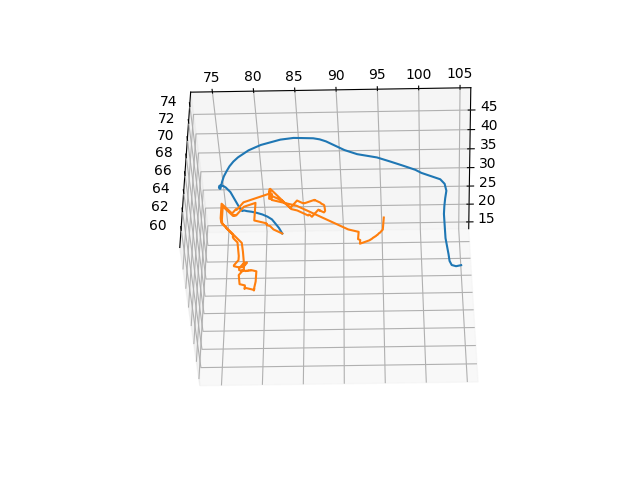

In [26]:
### vizualise streamline
states = torch.stack(all_states)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0][:], env.referenceStreamline_ijk.T[1][:], env.referenceStreamline_ijk.T[2][:])
ax.plot3D(states.T[0][:], states.T[1][:], states.T[2][:])

In [31]:
state = env.reset()
state, _, _, _ = env.step(env._get_best_action())
print(env.lineDistance(state))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

